Tutorial 6: Lens Modeling
=========================

When modeling complex source's with parametric profiles, we quickly entered a regime where our non-linear search was
faced with a parameter space of dimensionality N=20+ parameters. This made the model-fitting inefficient and likely to
infer a local maxima.

Inversions do not suffer this problem, meaning they are a very a powerful tool for modeling strong lenses. Furthermore,
they have *more* freemdom than parametric light profiles because they do not relying on specific analytic light
distributions and a symmetric profile shape. This will allow us to fit more complex mass models and ask ever more
interesting scientific questions!

However, inversion do have some short comings that we need to be aware of before we use them for lens modeling. That`s
what we cover in this tutorial.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


__Initial Setup__

We'll use the same strong lensing data as the previous tutorial, where:

 - The lens galaxy's light is omitted.
 - The lens galaxy's total mass distribution is an `EllIsothermal` and `ExternalShear`.
 - The source galaxy's `LightProfile` is an `EllSersic`.

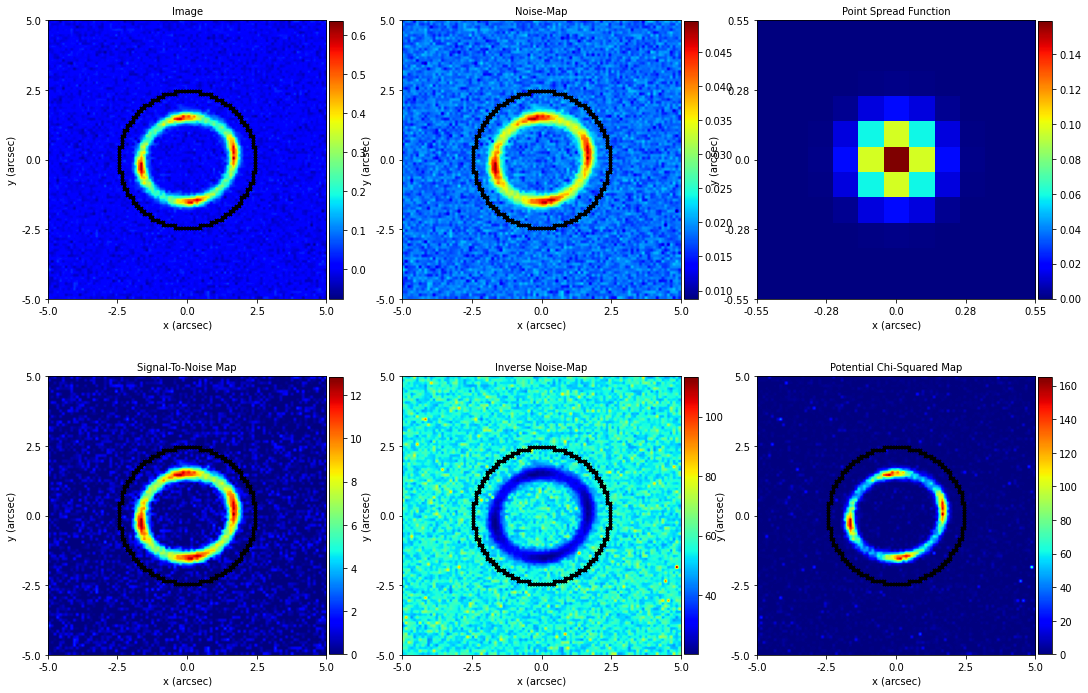

In [2]:
dataset_name = "mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "no_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=2.5,
)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

This function fits the imaging data with a tracer, returning a `FitImaging` object.

In [3]:


def perform_fit_with_lens__source_galaxy(imaging, lens_galaxy, source_galaxy):

    mask = al.Mask2D.circular_annular(
        shape_native=imaging.shape_native,
        pixel_scales=imaging.pixel_scales,
        sub_size=1,
        inner_radius=0.5,
        outer_radius=2.2,
    )

    imaging = imaging.apply_mask(mask=mask)

    tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

    return al.FitImaging(imaging=imaging, tracer=tracer)


__Unphysical Solutions__

To see the short-comings of an inversion, we begin by performing a fit where the lens galaxy has an incorrect 
mass-model (I've reduced its Einstein Radius from 1.6 to 0.8). This is a mass model the non-linear search may sample at 
the beginning of a model-fit.

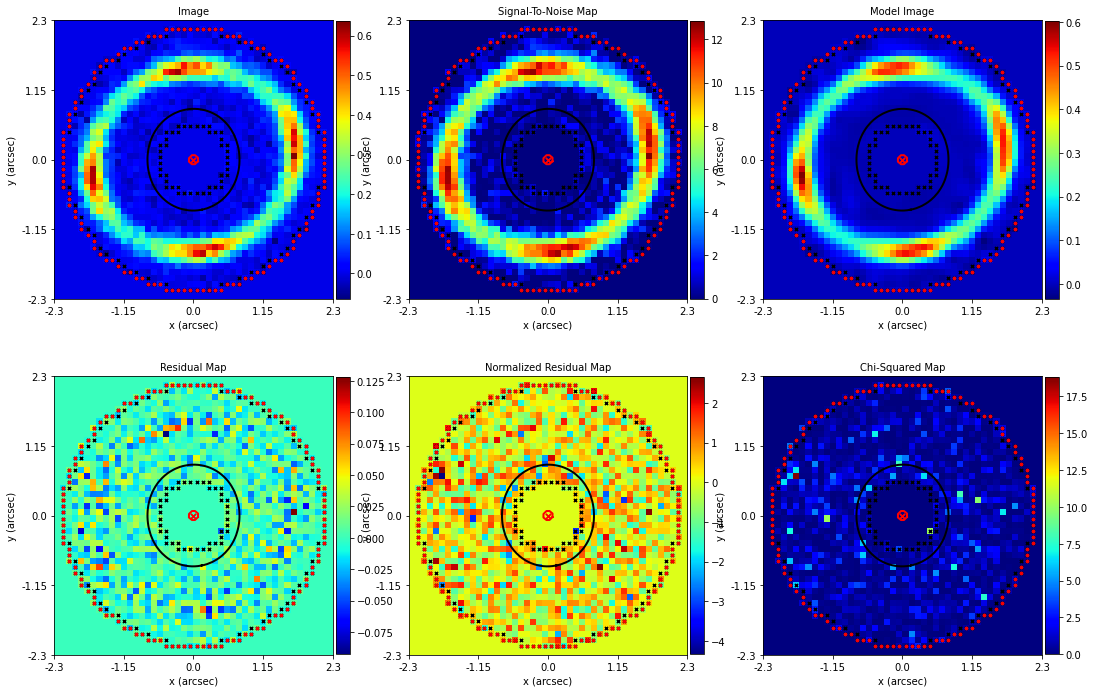

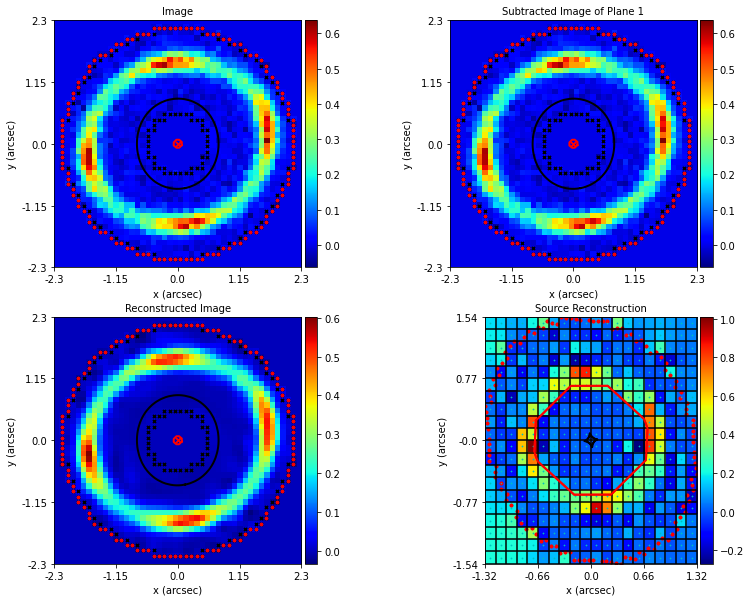

In [4]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=0.8,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, angle=45.0),
    ),
    shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.05)),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(20, 20)),
    regularization=al.reg.Constant(coefficient=1.0),
)

fit = perform_fit_with_lens__source_galaxy(
    imaging=imaging, lens_galaxy=lens_galaxy, source_galaxy=source_galaxy
)

include_2d = aplt.Include2D(mask=True)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.subplot_of_planes(plane_index=1)

What happened!? This incorrect mass-model provides a really good fit to the image! The residuals and chi-squared-map 
are as good as the ones we saw in the previous tutorials.

How can an incorrect lens model provide such a fit? Well, as I'm sure you noticed, the source has been reconstructed 
as a demagnified version of the image. Clearly, this is not a physical solution or a solution that we want our 
non-linear search to find, but for inversion's the reality is these solutions eixst.

This is not necessarily problematic for lens modeling. Afterall, the source reconstruction above is extremely complex, 
it requires a lot of source pixels to fit the image accurately and its lack of smoothness will be heavily penalized
by regularization when we compute the Bayesian evidence. Indeed, its Bayesian evidence is much lower than the true lens
model solution:

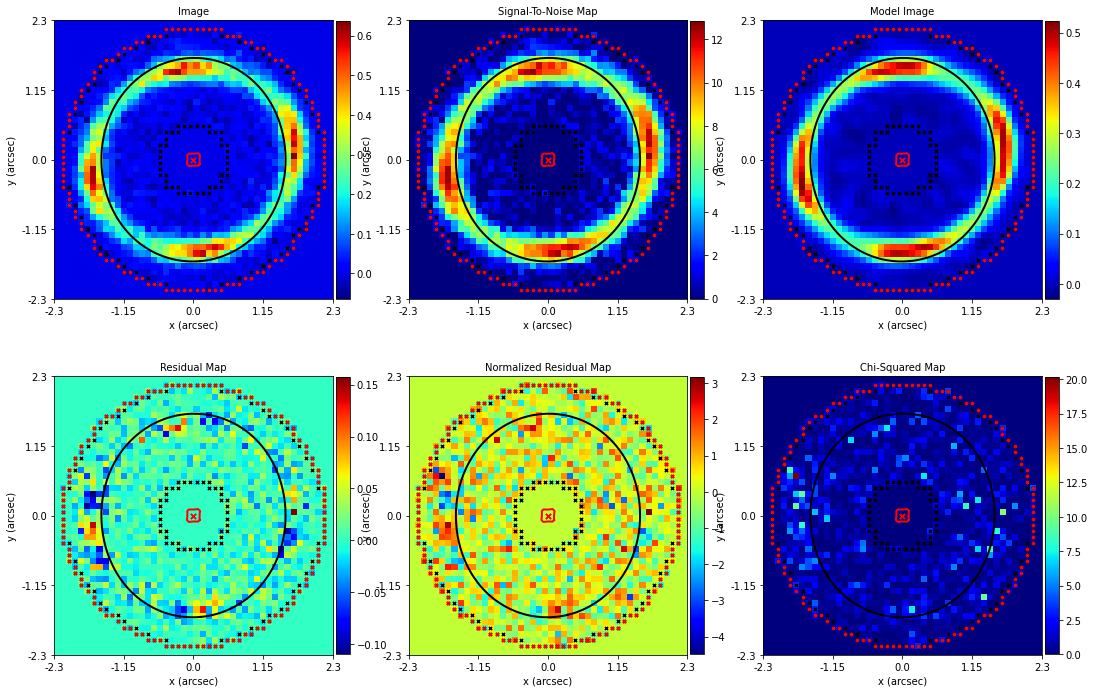

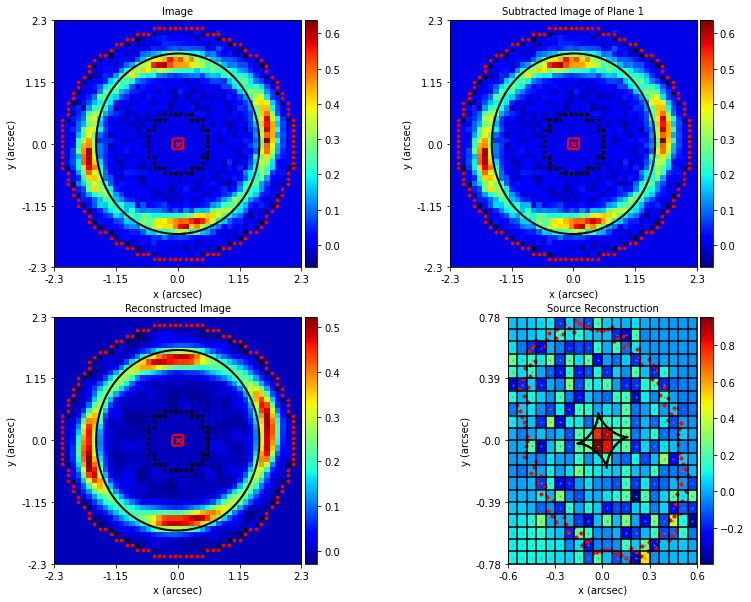

Bayesian Evidence of Incorrect Fit:
2669.029248509356
Bayesian Evidence of Correct Fit:
2778.6734479714814


In [5]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllIsothermal(
        centre=(0.0, 0.0),
        einstein_radius=1.6,
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, angle=45.0),
    ),
    shear=al.mp.ExternalShear(elliptical_comps=(0.05, 0.05)),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(20, 20)),
    regularization=al.reg.Constant(coefficient=1.0),
)

correct_fit = perform_fit_with_lens__source_galaxy(
    imaging=imaging, lens_galaxy=lens_galaxy, source_galaxy=source_galaxy
)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=correct_fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.subplot_of_planes(plane_index=1)

print("Bayesian Evidence of Incorrect Fit:")
print(fit.log_evidence)
print("Bayesian Evidence of Correct Fit:")
print(correct_fit.log_evidence)

The `log_evidence` *is* lower. However, the difference in `log_evidence` is not *that large*. This could be a problem 
for the non-linear search, as it will see many solutions in parameter space with high `log_evidence` values. Furthermore, 
these solutions occupy a *large volumne* of parameter space (e.g. everywhere the lens model that is wrong). This makes 
it easy for the non-linear search to get lost searching through these unphysical solutions and, unfortunately, inferring 
an incorrect lens model (e.g. a local maxima).

There is no simple fix for this, and it is the price we pay for making the inversion has so much flexibility in how it
reconstructs the source's light. The solution to this problem? Search chaining. In fact, this is the problem that lead
us to initially conceive of search chaining! 

The idea is simple, we write a pipeline that begins by modeling the source galaxy's light using a light profile, thereby
initializing the priors for the lens galaxy's light and mass. Then, when we switch to an `Inversion` in the next 
search, the mass model starts in the correct regions of parameter space and does not get lost sampling these 
incorrect solutions.

The following paper discusses these solutions in more detail (https://arxiv.org/abs/2012.04665).

__Light Profiles__

We can also model strong lenses using light profiles and an inversion at the same time. We do this when we want to 
simultaneously fit and subtract the lens galaxy's light using a light profile whilst reconstructing the source's
light using an inversion. 

To do this, all we have to do is give the lens galaxy a light profile and use the tracer and fit objects we are used 
too:.

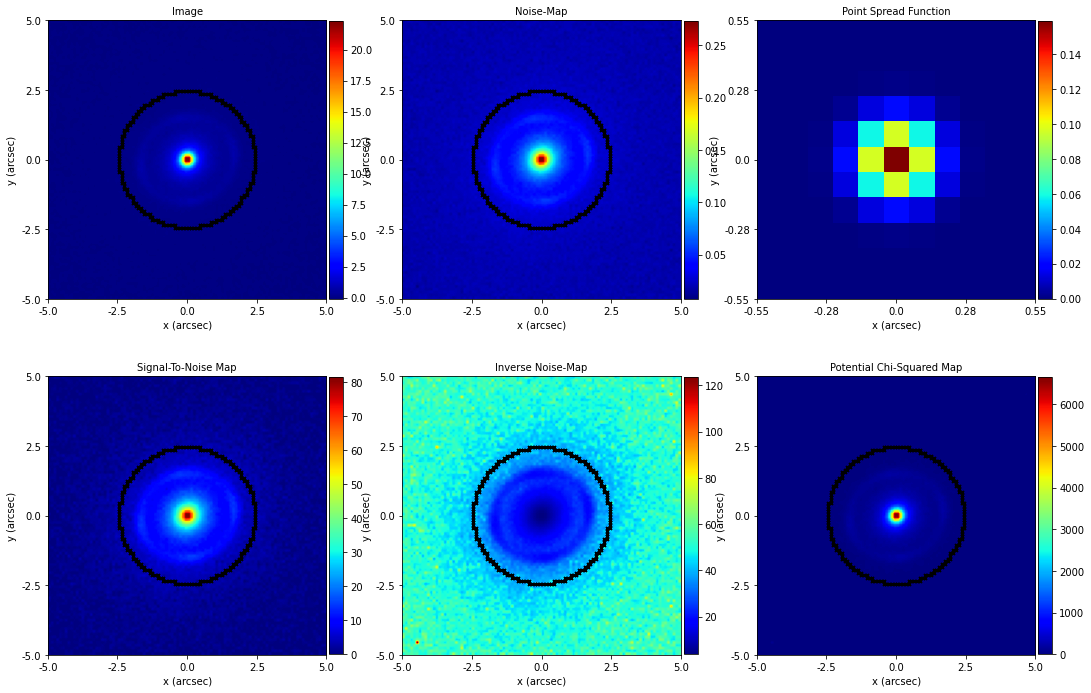

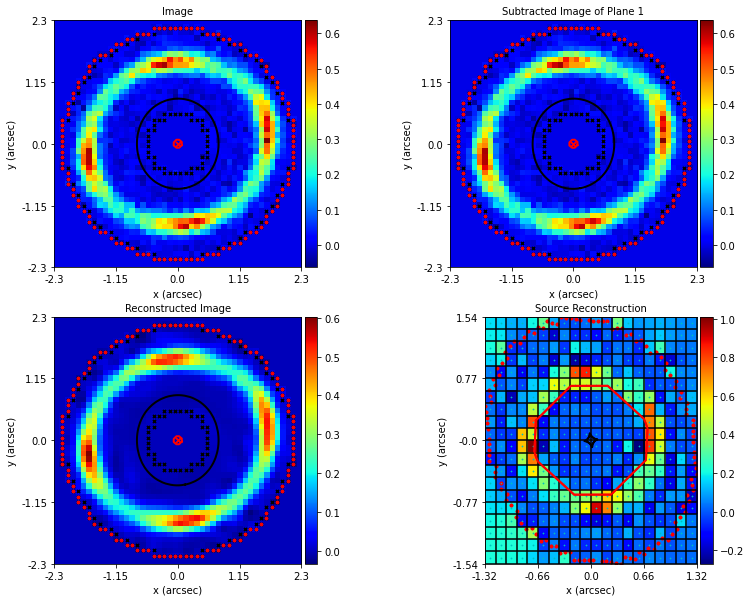

In [6]:
dataset_name = "light_sersic__mass_sie__source_sersic"
dataset_path = path.join("dataset", "imaging", "with_lens_light", dataset_name)

imaging = al.Imaging.from_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    pixel_scales=0.1,
)

mask = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=2.5,
)

imaging_plotter = aplt.ImagingPlotter(
    imaging=imaging, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter.subplot_imaging()

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_of_planes(plane_index=1)

When fitting such an image we now want to include the lens's light in the analysis. Lets update our mask to be 
circular so that it includes the central regions of the image and lens galaxy.

In [7]:
mask = al.Mask2D.circular(
    shape_native=imaging.shape_native,
    pixel_scales=imaging.pixel_scales,
    sub_size=2,
    radius=2.5,
)

imaging = imaging.apply_mask(mask=mask)

As I said above, performing this fit is the same as usual, we just give the lens galaxy a `LightProfile`.

In [8]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    bulge=al.lp.EllSersic(
        centre=(0.0, 0.0),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, angle=45.0),
        intensity=1.0,
        effective_radius=0.8,
        sersic_index=4.0,
    ),
    mass=al.mp.EllIsothermal(
        centre=(0.0, 0.0), elliptical_comps=(0.1, 0.0), einstein_radius=1.6
    ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    pixelization=al.pix.Rectangular(shape=(20, 20)),
    regularization=al.reg.Constant(coefficient=1.0),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

This fit will now subtract the lens galaxy's light from the image and fits the resulting source-only image with the 
inversion. When we plot the image, a new panel on the sub-plot appears showing the model image of the lens galaxy.

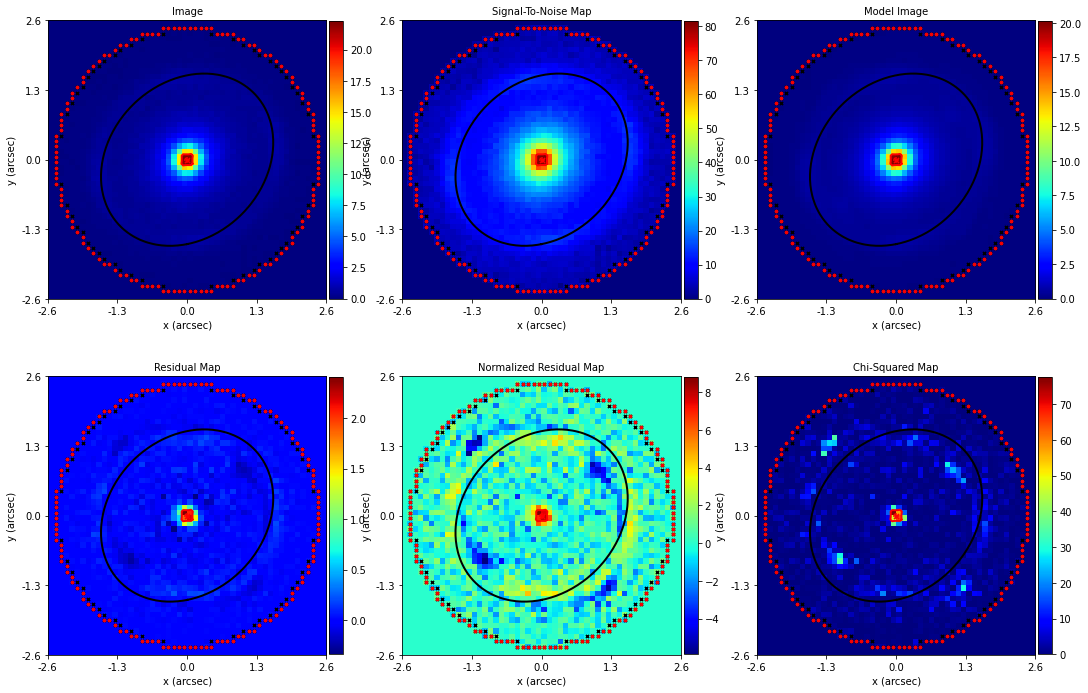

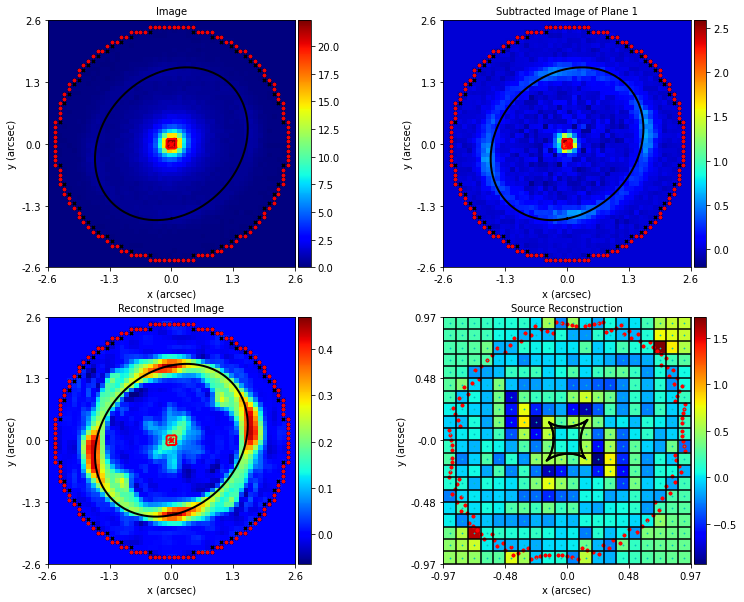

In [9]:
fit = al.FitImaging(imaging=imaging, tracer=tracer)

include_2d = aplt.Include2D(mask=True)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.subplot_of_planes(plane_index=1)

Of course if the lens subtraction is rubbish so is our fit. We can therefore be sure that our lens model will want to 
fit the lens galaxy's light accurately (below, I've decreased the lens galaxy intensity from 1.0 to 0.5 to show the
result of a poor lens light subtraction).

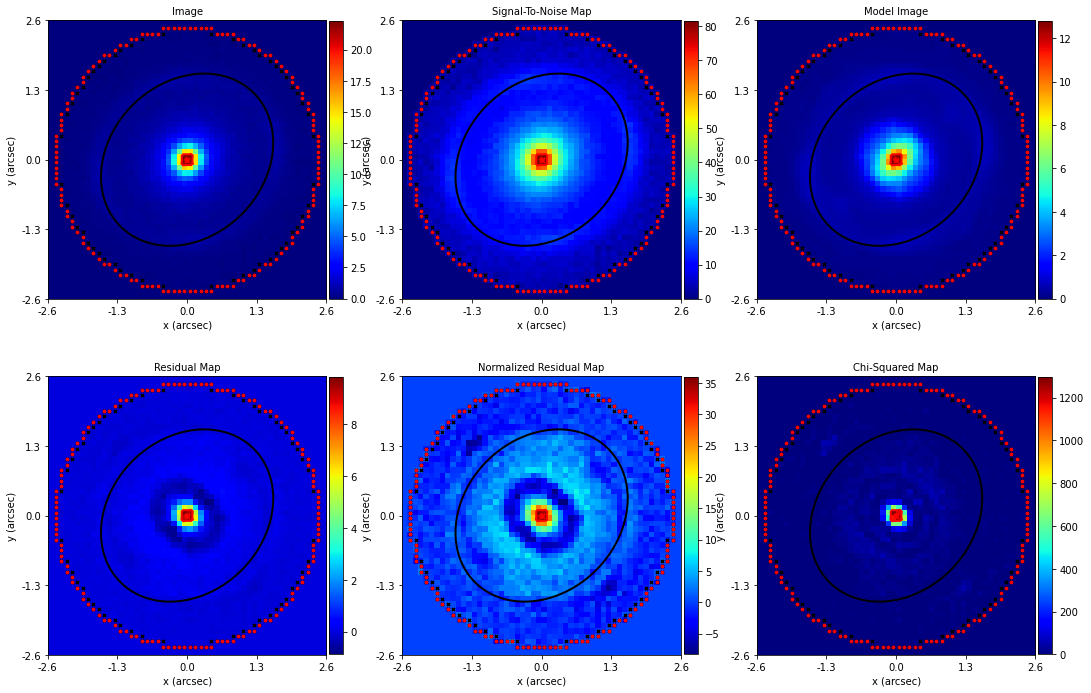

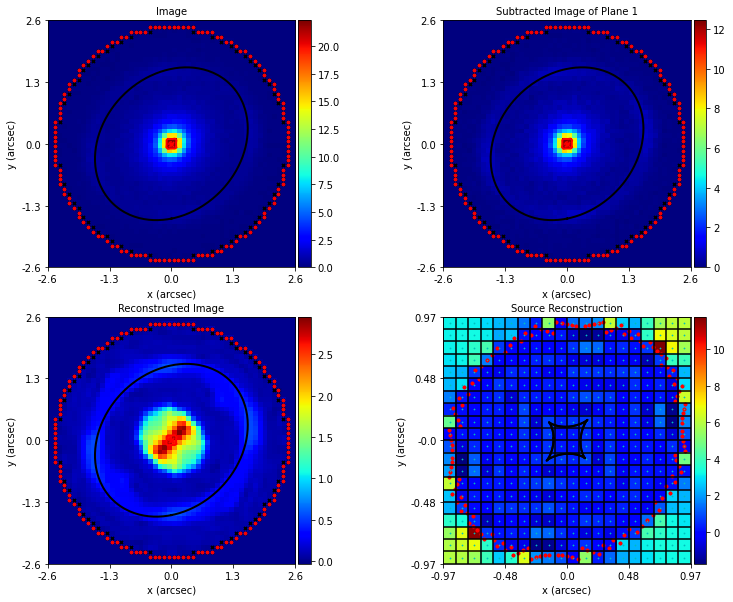

In [10]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    bulge=al.lp.EllSersic(
        centre=(0.0, 0.0),
        elliptical_comps=al.convert.elliptical_comps_from(axis_ratio=0.9, angle=45.0),
        intensity=0.5,
        effective_radius=0.8,
        sersic_index=4.0,
    ),
    mass=al.mp.EllIsothermal(
        centre=(0.0, 0.0), elliptical_comps=(0.1, 0.0), einstein_radius=1.6
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

fit = al.FitImaging(imaging=imaging, tracer=tracer)

include_2d = aplt.Include2D(mask=True)

fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, include_2d=include_2d)
fit_imaging_plotter.subplot_fit_imaging()
fit_imaging_plotter.subplot_of_planes(plane_index=1)

__Wrap Up__

And with that, we're done. I'll end by pointing out a few things about what we've covered to get you thinking about 
the next tutorial on adaption.
    
 - When the lens galaxy's light is subtracted perfectly it leaves no residuals. However, if it isn't subtracted 
 perfectly it does leave residuals, which will be fitted by the inversion. If the residual are significant this is 
 going to impact the source reconstruction negatively and can lead to some pretty nasty systematics. In the next 
 chapter, we'll learn how our adaptive analysis can prevent this residual fitting.